In [41]:
#%matplotlib qt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import ZebraLib as zb
from scipy.optimize import curve_fit

def mean(array):
    mean_mi = 0
    for i in range(len(array)):
        mean_mi += array[i]
    mean_mi = mean_mi/len(array)
    return mean_mi

def incert_A(array):
    return ufloat(array.mean(), array.std(ddof=1)/np.sqrt(len(array)))

def  incert_B(array, precision):
    array_er = []
    for i in range(len(array)):
        array_er.append(ufloat(array[i], precision/np.sqrt(3)))
    return array_er

#Import de dados - Experimento
df = pd.read_excel('D:/UNESP/7-semestre-EngMec/Lab. Mec Flu I/Relatório_4/dados_exp.xlsx', index_col=0)
df_calib = pd.read_excel('D:/UNESP/7-semestre-EngMec/Lab. Mec Flu I/Relatório_4/curva_calibração_CQ.xlsx')

In [42]:
df

,col1,col2,d_col,vel
0,2.7,17.4,14.7,28.43
1,16.5,4.0,12.5,27.75
2,15.7,4.8,10.9,26.04
3,14.8,5.8,9.0,23.95
4,13.9,6.8,7.1,21.70


## Solução polinomial - a curva não se ajusta

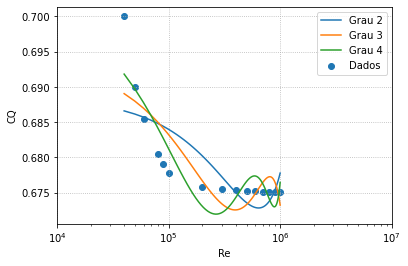

In [43]:
new_x = np.linspace(df_calib.x.min(), df_calib.x.max(),100)

fig, ax = plt.subplots()
ax.set(ylabel='CQ', xlabel='Re')

for i in range(2, 5):
    poly = zb.fit((df_calib.x), df_calib.y, i)
    ax.plot(new_x, poly(new_x), label =f'Grau {i}')

ax.scatter(df_calib.x, df_calib.y, label ='Dados')
ax.legend()
ax.grid(ls='dotted')
ax.set_xlim(1e4, 1e7)
ax.set_xscale('log')

## Solução hiperbolica usando curve_fit 
Melhor aproximação por mínimo quadrados utilizando a função genérica 
$f(x) = \frac{1}{x^a}b + c$

In [44]:
#Modelo
def func(x, a, b, c):
    return (1/(x**a))*b + c

#Fit do modelo
popt, pcov = curve_fit(func, df_calib.x, df_calib.y, p0=[1.9, 1, 0])

f(x) = 1/2.256*599671108.436 + 0.675


array([2.25592396e+00, 5.99671108e+08, 6.75125991e-01])

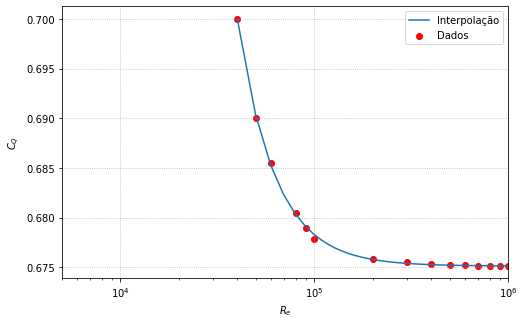

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set(ylabel=r'$C_Q$', xlabel=r'$R_e$')

ax.plot(new_x, func(new_x, *popt), label =f'Interpolação')
ax.scatter(df_calib.x, df_calib.y, c='r', label ='Dados')

ax.legend()
ax.grid(ls='dotted')
ax.set_xlim(0.5e4, 1e6)
ax.set_xscale('log')

fig.savefig('aproxim.pdf', bbox_inches='tight')

#Resultados dos coeficientes p/ o melhor polinômio
print(f'f(x) = 1/{popt[0]:.3f}*{popt[1]:.3f} + {popt[2]:.3f}')
popt 

## Iterando para entrar o melhor valor

In [46]:
D = 0.07816
area_D = (np.pi*(D**2))/4 

def coef_CQ(x):
    return func(x, *popt)

def Num_Re(v, D=0.07816):
    #visc_din=15.06e-6 #Visc. dina. Ar
    #return (v*D)/visc_din
    return (v*D*1.205)/18.13e-6
    
def Vazão_Q(cq, delta_h,  D=0.07816):
    rho_agua, rho_ar, g = 998.20, 1.205, 9.81
    Ad = 0.45*area_D
    delta_P = rho_agua*g*(delta_h)
    return cq*Ad*np.sqrt((2*delta_P)/rho_ar)

def iterador(delta_h, verbose=False):
    v_sol = []
    Re = 1e6

    for i in range(5):
        cq0 = coef_CQ(Re)
        Q = Vazão_Q(cq0, delta_h/100)
        V = Q/(area_D)                  #Velocidade do escoamento
        Re = Num_Re(V)
        
        if verbose:
            v_sol.append([cq0, Q, V, Re])
        else:
            v_sol.append(V)

    return np.asarray(v_sol)

In [47]:
#Iteração para o 1 valor 
pd.DataFrame(iterador(14.7, True), columns=['CQ', 'Q', 'V', 'Re'])

,CQ,Q,V,Re
0,0.675143,0.071251,14.850190,77144.648229
1,0.680782,0.071846,14.974217,77788.949384
2,0.680677,0.071835,14.971904,77776.936012
3,0.680679,0.071835,14.971947,77777.157049
4,0.680679,0.071835,14.971946,77777.152981


In [48]:
#Calculando as velocidades teóricas e comparando
F = []
for i in df.d_col:
    F.append(iterador(i, False)[4])
pd.DataFrame({'VT':F, 'VE':df.vel, 'ER':abs(df.vel-F)/F*100})

,VT,VE,ER
0,14.971946,28.43,89.888477
1,13.828326,27.75,100.675055
2,12.933517,26.04,101.337351
3,11.783431,23.95,103.251490
4,10.508905,21.70,106.491542
